# Production Planning

In [40]:
from io import StringIO

import numpy as np
import pandas as pd
import pyomo.environ as pyo
import matplotlib.pyplot as plt

# Data from Problem 12.3 from the book Model Building in Mathematical Programming (H. Paul Williams)
# Two entries in the top row changed

file = StringIO("""
10 6 8 4 11 9 3
0.5 0.7 – – 0.3 0.2 0.5
0.1 0.2 – 0.3 – 0.6 –
0.2 – 0.8 – – – 0.6
0.05 0.03 – 0.07 0.1 – 0.08
 – – 0.01 – 0.05 – 0.05
 """)

# Column names for the big Data Frame
columns = ["Profit", "Grinding", "V_drilling", "H_drilling", "Boring", "Planing"]

production = pd.read_csv(file, header=None, sep="\s+", na_values=["–"]).fillna(0).T
production.columns = columns
production.reindex(list(range(production.shape[0])))
production.index.name = "Product"

# keep profit coefficients in a separate series
profit = production["Profit"]
production.drop("Profit", axis=1, inplace=True)

# A little modification to the profit data to make the products more "competitive" against each other
profit[0] = 7
profit[4] = 8

# Numbers of machines of different types
nb_machines = pd.Series(
    [4, 2, 3, 1, 1], 
    index=["Grinding", "V_drilling", "H_drilling", "Boring", "Planing"],
    dtype = 'float64'
)
# total hours per month = 24 working days times 8 hours
hours = 24 * 8

production.drop("Profit", axis = 1, inplace = True)
display("production", production)
display("profit", profit)
display(nb_machines)

'production'

,Grinding,V_drilling,H_drilling,Boring,Planing
Product,,,,,
0,0.5,0.1,0.2,0.05,0.00
1,0.7,0.2,0.0,0.03,0.00
2,0.0,0.0,0.8,0.00,0.01
3,0.0,0.3,0.0,0.07,0.00
4,0.3,0.0,0.0,0.10,0.05
5,0.2,0.6,0.0,0.00,0.00
6,0.5,0.0,0.6,0.08,0.05


'profit'

Product
0    7.0
1    6.0
2    8.0
3    4.0
4    8.0
5    9.0
6    3.0
Name: Profit, dtype: float64

Grinding      4.0
V_drilling    2.0
H_drilling    3.0
Boring        1.0
Planing       1.0
dtype: float64

## Nominal Model

The nominal model for this production planning problem is given by

$$
\begin{align*}
\min \; &\; \sum_{p\in P} c_p x_p \\
\text{s.t.} \; &\; \sum_{p\in P} a_{p, r} x_p \leq b_r & \forall r\in R \\
& \; x_p \geq 0 & \forall p\in P
\end{align*}
$$

where

* decision variable $x_p$ is the production of product for $p\in P$, 
* $c_p$ is the profit contribution of each unit of product $p\in P$ that is produced, 
* $a_{r,p}$ are the hours of resource machine $r\in R$ required to produce one unit of $p\in P$, and
* $b_r = n_r H$ is the total available hours of resource $r\in R$, where $n_r$ is the number of available machines of type $r$ and $H$ is the planning horizon in hours.

In generic form, the model can be written

$$
\begin{align*}
\min \; & \; c^\top x \\
\text{s.t.} \; & \; A x \leq b \\
& \; x \geq 0
\end{align*}
$$

The following cell presents a function that creates and solves a Pyomo model for the generic linear program where the data is given in Pandas DataFrames.

In [17]:
# creating and solving a nominal production model

def lp(a, b, c, title=None):
    """Returns a generic linear program where data is given in Pandas DataFrames.
    """
    
    m = pyo.ConcreteModel(title)

    m.P = pyo.Set(initialize=c.index)
    m.R = pyo.Set(initialize=b.index)

    # Variables = how much of each product we make
    m.x = pyo.Var(m.P, domain=pyo.NonNegativeIntegers)
    
    @m.Objective(sense=pyo.maximize)
    def objective(m):
        return c @ m.x

    @m.Constraint(m.R)
    def resource(m, r):
        return a[r] @ m.x <= b[r]
    
    m.solver = pyo.SolverFactory("gurobi")
    m.solver.solve(m)
    
    return m


m = lp(a = production, 
       b = nb_machines * hours, 
       c = profit, 
       title = "Nominal Production Planning")

m.display()

Model Nominal Production Planning

  Variables:
    x : Size=7, Index=P
        Key : Lower : Value  : Upper : Fixed : Stale : Domain
          0 :     0 :    0.0 :  None : False : False : NonNegativeIntegers
          1 :     0 :  116.0 :  None : False : False : NonNegativeIntegers
          2 :     0 :  720.0 :  None : False : False : NonNegativeIntegers
          3 :     0 :   -0.0 :  None : False : False : NonNegativeIntegers
          4 :     0 : 1885.0 :  None : False : False : NonNegativeIntegers
          5 :     0 :  601.0 :  None : False : False : NonNegativeIntegers
          6 :     0 :   -0.0 :  None : False : False : NonNegativeIntegers

  Objectives:
    objective : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 26945.0

  Constraints:
    resource : Size=5
        Key        : Lower : Body               : Upper
            Boring :  None :             191.98 : 192.0
          Grinding :  None :  766.9000000000001 : 768.0
        H_

In [64]:
# Simulation like in the textbook file

Nsim = 100
big_M = 10 ** 5
desired_production = pd.Series({i : m.x[i]() for i in production.index})
import itertools

simulated_profits = pd.Series([0.0 for i_sim in range(Nsim)])
simulated_production = pd.DataFrame(np.zeros((Nsim, len(profit)), 'int64'),
                                   columns = production.index)

for i_sim in range(Nsim):
    a_pert = production * (0.9 + 0.2 * np.random.rand(*production.shape))
    total_profit = 0.0
    resources_left = nb_machines * hours
    order_of_products = np.random.permutation(production.index)
    
    for p in order_of_products:
        # max qu
        produced_quantity = min([np.floor(resources_left[i] / a_pert.loc[p, i]) 
                                 if a_pert.loc[p, i] > 10 **-4 else desired_production[p]
                                 for i in production.columns])
        
        total_profit += produced_quantity * profit[p]
        simulated_production.loc[i_sim, p] = produced_quantity
        # update remaining resources
        for i in production.columns:
            resources_left[i] -= produced_quantity * a_pert.loc[p, i]
    
    simulated_profits[i_sim] = total_profit

display(simulated_profits.mean())
display(simulated_production.mean())

production_comparison = pd.concat([desired_production, simulated_production.mean()])

26099.29

Product
0       0.00
1      74.63
2     708.00
3       0.00
4    1839.65
5     585.59
6       0.00
dtype: float64

In [65]:
production_comparison = pd.concat([desired_production, simulated_production.mean()], axis = 1)
production_comparison.columns = ["Desired", "Realized"]
production_comparison.to_latex()

'\\begin{tabular}{lrr}\n\\toprule\n{} &  Desired &  Realized \\\\\nProduct &          &           \\\\\n\\midrule\n0       &      0.0 &      0.00 \\\\\n1       &    116.0 &     74.63 \\\\\n2       &    720.0 &    708.00 \\\\\n3       &     -0.0 &      0.00 \\\\\n4       &   1885.0 &   1839.65 \\\\\n5       &    601.0 &    585.59 \\\\\n6       &     -0.0 &      0.00 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [66]:
(simulated_profits.mean() - 26945) / 26945 * 100

-3.138652811282238

## Displaying the solution

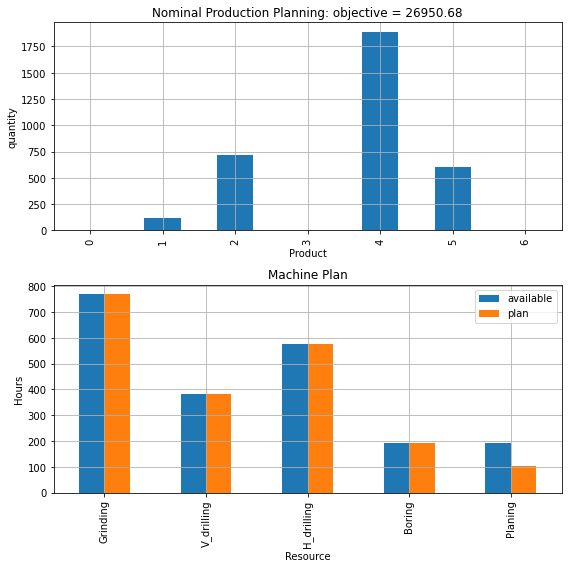

In [ ]:
def display_plan(m, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(2, 1, figsize=(8, 8))

    x = pd.Series({p: m.x[p]() for p in m.P}, name=m.name)
    x.plot(ax=ax[0], kind="bar", xlabel="Product", ylabel="quantity",
           title=m.name  + f": objective = {m.objective():0.2f}", grid=True)

    resources = pd.concat([hours*nb_machines, production.T @ x], axis=1)
    resources.columns = ["available", "plan"]
    resources.plot(ax=ax[1], kind="bar", xlabel="Resource", ylabel="Hours", title="Machine Plan", grid=True)
    
    fig.tight_layout()
    
    return ax

display_plan(m);

## Are Nominal Solutions Robust to Uncertain Parameters?

Can the nominal production plan be executed with the available resources? 

The answer is yes if the linear program accurately captures all of the resource constraints. That implies precise and accurate knowledge of the processing times for each task on each machine, and no other constraints are present. If so then it will be possible to execute the nominal plan with the available resources.

But what if the parameters are not known with precision and accuracy? Suppose, for example, the time required to perform operation $r$ on product $p$ is $\tilde{a]_{r, p}$ instead of the nominal value $a_{r, p}$, where

$$ a_{r, p} - a'_{r, p} \leq \tilde{a}_{r, p} \leq a_{r, p} + a'_{r, p}$$

and $a'_{r, p}$ is a maximum perturbation defining an interval of possible parameters values. A robust production plan is a plan $x_p$ for $p\in P$ which satisfies the problem constraints for all possible realizations of the parameters $\tilde{a}_{r, p}$.

The following cells present use simulation to demonstrate some of the consequences of uncertainty for the optimization of production planning.

### Scenario Generation

To test whether this robustness property holds for the example, the following cell uses a single parameter $d_{max}$ to define the maximum deviation in each parameter $a_{r, p}$.

$$
\begin{align*}
a'_{r, p} = d_{max} a_{r, p}
\end{align*}
$$

A scenario refers to a single realization of the matrix of values $\tilde{a}_{r, p}$ for all $r\in R$ and $p \in P$. The following cell introduces a scenario generator that can be used for simulations. The scenario generator uses a quasirandom low-discrepancy sequence to more evenly sample the uncertainty space.

In [ ]:
from scipy.stats import qmc

# a Python generator
def scenario_generator(production, d_max=0):
    nr, np = production.shape
    sampler = qmc.Sobol(d=np*nr)
    while True:
        z = 2*(sampler.random().reshape(nr, np) - 0.5)
        yield (1 + d_max * z) * production
        
# create an instance of the generator
d_max = 0.05
scenario = scenario_generator(production, d_max)

# demonstrate use
for n in range(3):
    a = next(scenario)
    print(f"\nScenario {n}:")
    print(a)


Scenario 0:
         Grinding  V_drilling  H_drilling    Boring   Planing
Product                                                      
0        0.491525    0.100198    0.205004  0.051715  0.000000
1        0.698691    0.194797    0.000000  0.031130  0.000000
2        0.000000    0.000000    0.794492  0.000000  0.010063
3        0.000000    0.289505    0.000000  0.067116  0.000000
4        0.296508    0.000000    0.000000  0.101002  0.050069
5        0.209002    0.624423    0.000000  0.000000  0.000000
6        0.492751    0.000000    0.613353  0.080746  0.050041

Scenario 1:
         Grinding  V_drilling  H_drilling    Boring   Planing
Product                                                      
0        0.503030    0.095520    0.195445  0.048113  0.000000
1        0.729904    0.203196    0.000000  0.029001  0.000000
2        0.000000    0.000000    0.829487  0.000000  0.009673
3        0.000000    0.303952    0.000000  0.070409  0.000000
4        0.304711    0.000000    0.000000  0

The next cell solves for the nominal production plan using nominal process parameters $a_{r, p}$. The cell tests whether the nominal production plan satisfies all of the production constraints for a random realization $\tilde{a}_{r, p}$.

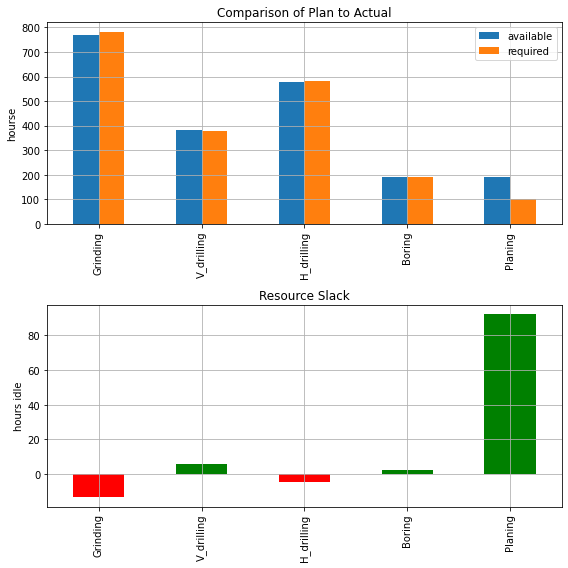

In [ ]:
# define a nominal set of parameter values

# solve for production plan using nominal parameter values
m = lp(a = production,
       b = nb_machines * hours, 
       c = profit,
       title = "Nominal Production Planning")

x = pd.Series({p: m.x[p]() for p in m.P})

d_max = 0.05
scenaro = scenario_generator(production, d_max)
a = next(scenario)

b = pd.concat([nb_machines * hours, a.T @ x], axis=1)
b.columns = ["available", "required"]
b["slack"] = b["available"] - b["required"]

fig, ax = plt.subplots(2, 1, figsize=(8, 8))

b[["available", "required"]].plot(ax=ax[0], kind="bar", grid=True, 
                                  ylabel="hourse", title="Comparison of Plan to Actual")
b["slack"].plot(ax=ax[1], kind="bar", grid=True, legend=False, title="Resource Slack",
           color=(b["slack"] > 0).map({True: 'g', False: 'r'}), ylabel="hours idle")
fig.tight_layout()

For a more systematic assessment of the "here-and-now" decision to use the nominal production plan, the following cell simulates the resource requirements for $N$ scenarios that are possible for the given uncertainty set.

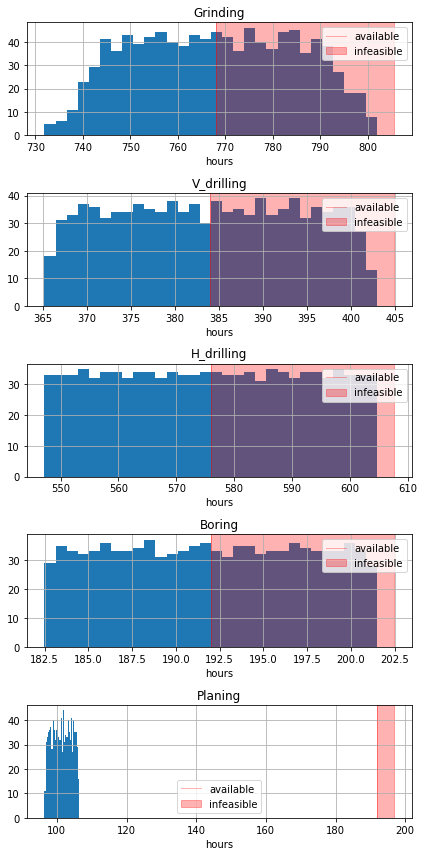

In [ ]:
dmax = 0.05
scenario = scenario_generator(production, dmax)

s = []
N = 1000
for n in range(N):
    a = next(scenario)
    s.append((a.T @ x).to_numpy())

s = pd.DataFrame(s, columns=a.columns)

fig, ax = plt.subplots(len(nb_machines), 1, figsize=(6, 12))
for k, r in enumerate(nb_machines.index):
    s[r].hist(ax=ax[k], bins=30)
    ax[k].set_title(r)
    ax[k].set_xlabel("hours")
    ax[k].axvline(nb_machines[r] * hours, lw=1, alpha=0.3, color="r")
    ax[k].axvspan(nb_machines[r] * hours, ax[k].get_xlim()[1], alpha=0.3, color='r')
    ax[k].legend(["available", "infeasible"])

fig.tight_layout()

Each of the active constraints appears to be violated on about half of all simulations. But the situation is worse than that because, for a given simulation, a violation of any constraint is an unacceptable result. The next cell computes how many simulations violate at least one constraint. 

In [ ]:
print(f"{N - (s <= nb_machines * hours).T.all().sum()} out of {N} simiulations violate at least one constraint.")

936 out of 1000 simiulations violate at least one constraint.


### Reduced profitability

In [ ]:
# nominal solution

m = lp(a = production,
       b = nb_machines * hours, 
       c = profit, 
       title = "Nominal Production Planning")

x_nominal = np.array([m.x[p]() for p in m.P])
print(f"Nominal profit = {profit @ x_nominal}")

# production scenarios
dmax = 0.05
scenario = scenario_generator(production, dmax)

s = []
N = 100
for n in range(N):
    m = lp(a = next(scenario),
       b = nb_machines * hours, 
       c = profit, 
       title = "Production Planning")
    
    @m.Constraint(m.P)
    def limit(m, p):
        return m.x[p] <= x_nominal[p]
    
    m.solver.solve(m)
    s.append(m.objective())


Nominal profit = 26950.67506


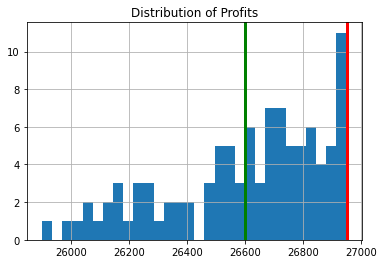

In [ ]:
s = pd.Series(s)
ax = s.hist(bins=30)
ax.set_title("Distribution of Profits")
ax.axvline(m_nominal.objective(profit @ x_nominal), color='r', lw=3)
ax.axvline(s.mean(), color='g', lw=3)

In [ ]:

    m = lp(a = next(scenario),
           b = nb_machines * hours, 
           c = profit, 
           title = "Production Planning")

s = []
N = 1000
for n in range(N):
    a = next(scenario)

    m.
    s.append((a.T @ x).to_numpy())

s = pd.DataFrame(s, columns=a.columns)

fig, ax = plt.subplots(len(nb_machines), 1, figsize=(6, 12))
for k, r in enumerate(nb_machines.index):
    s[r].hist(ax=ax[k], bins=30)
    ax[k].set_title(r)
    ax[k].set_xlabel("hours")
    ax[k].axvline(nb_machines[r] * hours, lw=1, alpha=0.3, color="r")
    ax[k].axvspan(nb_machines[r] * hours, ax[k].get_xlim()[1], alpha=0.3, color='r')
    ax[k].legend(["available", "infeasible"])

fig.tight_layout()

## "Wait-and-See" and the Case of Perfect Information

In [ ]:
# simulate N "wait-and-see" production planning scenarios
X = []
s = []
N = 1000

for a in scenario_generator(N, production, dmax):
    m = lp(a = a,
           b = nb_machines * hours, 
           c = profit, 
           title = "Production Planning")
    s.append(m.objective())
    X.append([m.x[p]() for p in m.P])
    
X = pd.DataFrame(X, columns=profit.index)

The mean profit.

26715.86739

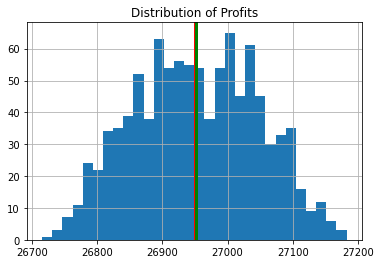

In [ ]:
s = pd.Series(s)
ax = s.hist(bins=30)
ax.set_title("Distribution of Profits")
ax.axvline(m_nominal.objective(), color='r', lw=3)
ax.axvline(s.mean(), color='g', lw=3)

s.min()

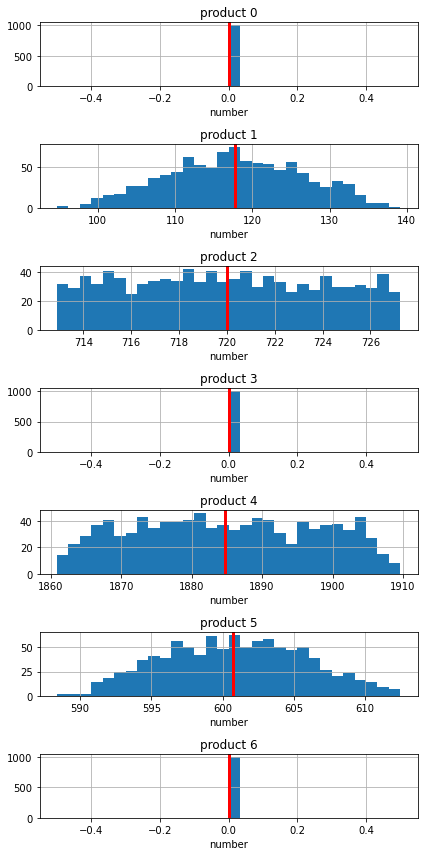

In [ ]:
fig, ax = plt.subplots(len(profit), 1, figsize=(6, 12))
for k, p in enumerate(profit.index):
    X[p].hist(ax=ax[k], bins=30)
    ax[k].set_title(f"product {p}")
    ax[k].set_xlabel("number")
    ax[k].axvline(x_nominal[p], color='r', lw=3)

fig.tight_layout()

## Robust Optimization to the "Here-and-Now" Decision

The robust optimization problem is given by

$$
\begin{align*}
\min \; &\; \sum_{p\in P} c_p x_p \\
\text{s.t.} \; &\; \sum_{p\in P} \tilde{a}_{p, r} x_p \leq b_r & \forall r\in R \\
& \; x_p \geq 0 & \forall p\in P
\end{align*}
$$

where $\tilde{a}_{p, r}$ denotes an uncertain coefficient. The uncertainty is modeled as 

$$\tilde{a}_{p, r} = a_{p, r} + z_{p, r} a'_{p, r}$$

where $a'_{p, r}$ is the maximum perturbation in coefficient $a_{p, r}$, and 

$$
\begin{align*}
| z_{p, r} | & \leq 1 & \forall p\in P, r \in R\\
\sum_{p\in P} |z_{p, r}| & \leq d & \forall r\in R
\end{align*}
$$

where $d$ is the 'uncertainty budget'. Together, these constraints form the uncertainty set $\cal{Z}$. The first constraint is a 'box' (or 'unit box', or 'interval') constraint that limits the range of each $\tilde{a}_{r, p} \in [a_{r,p} - a'_{r,p}, a_{r,p} + a'_{r,p}]$. For each $r\in R$, the floor (or integer part) of $d$ determines the number of elements of $\tilde{a}_{r, p}$ for $p \in P$ that can simultaneously reach the limits of the interval.

In [ ]:
def rc(a, a_perturbation, b, c, d=1, title=None):
    """Returns robust counterpart."""
    
    unc_budget = d
    
    m = pyo.ConcreteModel(title)

    m.P = pyo.Set(initialize=c.index)
    m.R = pyo.Set(initialize=b.index)

    # Variables = how much of each product we make
    m.x = pyo.Var(m.P, domain=pyo.NonNegativeReals)
    
    # sensitivity
    m.lam = pyo.Var(m.R, domain=pyo.NonNegativeReals)
    m.s = pyo.Var(m.R, m.P, domain=pyo.NonNegativeReals)
    
    @m.Objective(sense=pyo.maximize)
    def objective(m):
        return c @ m.x
    
    @m.Expression(m.R)
    def robustness_margin(m, r):
        return pyo.quicksum(m.s[r, :]) + unc_budget * m.lam[r]
    
    @m.Constraint(m.R)
    def resource(m, r):
        return a[r] @ m.x + m.robustness_margin[r] <= b[r]
    
    @m.Constraint(m.R, m.P)
    def sensitivity(m, r, p):
        return m.s[r, p] >= a_perturbation.loc[p, r] * m.x[p] - m.lam[r]
    
    pyo.SolverFactory("cbc").solve(m)
    
    return m


m = rc(a = production, 
       a_perturbation = dmax*production,
       b = nb_machines*hours,
       c = profit, 
       d = 1,
       title = "Robust Production Planning")

m.robustness_margin.display()

robustness_margin : Size=5
    Key        : Value
        Boring :  1.865353048
      Grinding :     5.596059
    H_drilling :    5.7029703
       Planing : 91.603636129
    V_drilling :   3.56439972


In [ ]:
# compute profits for each plan by taking dot product

x_robust = np.array([m.x[p]() for p in m.P])
display(x_robust.T @ profit)

26692.26277

## Value of Perfect Information

In [ ]:
s.mean() - x_robust.T @ profit

259.83320421400276